# Sentiment analysis of Formula 1 radio messages

This is the second notebook of the task of analyzing Formula 1 radios and extracting valuable information.

For the sentiment analysis, first, we will use **nltk** with Vader. 

First, I used `radios_raw.csv`. As this contianed lots of post-race radios, I have eliminated them, so the I will rerun the code using ``radios_filtered.csv``.

#### Importing necessar libraries and downloading vader lexicon

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from tqdm.notebook import tqdm

# Set styling for visualizations
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [25]:
# Download necessary NLTK resources for sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

--- 

### Loading the transcribed messages


In [26]:
data_path = "../../outputs/week4/radio_clean/radio_filtered.csv"

radio_data = pd.read_csv(data_path)

# Display basic information

print(f"Number of transcribed radio messages: {len(radio_data)}")

radio_data.head()

Number of transcribed radio messages: 529


,driver,radio_message,sentiment
0,1,"So don't forget Max, use your head please. Are...",NaN
1,1,"Okay Max, we're expecting rain in about 9 or 1...",NaN
2,1,You might find this lap that you meet a little...,NaN
3,1,Just another two or three minutes to get throu...,NaN
4,1,So settle into standard race management now Max.,NaN


--- 

### Initializing Vader sentiment analyzer

In [27]:
# Initializing the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Get the sentiment scores
def get_sentiment_scores(text):
    # I add an exception for if the radio message is empty
    if pd.isna(text) or text =="":
        return {"neg": 0 , "neu": 0, "pos": 0, "compound": 0}
    
    return sid.polarity_scores(text)

---
### Applying VADER

Moreover, I will modify our current Dataframe to add the sentiment analysis made by vader to it. Therefore, there will be *5 new columns:*

1. neg: number for specifying the ``negative`` component of the radio message.
2. pos: number for specifying the ``positive`` component of the radio message.
3. compound: the normalized, weighted composite score that represents overall sentiment of the text on a scale of -1 to 1.
4. sentiment: a final column whith the output of the sentiment. 

In [28]:
# We apply vader to each transcription

tqdm.pandas(desc = "Analyzing sentiment")
sentiment_scores = radio_data["radio_message"].progress_apply(get_sentiment_scores)

# Convert sentiment scores to Dataframe Columns

sentiment_df = pd.DataFrame(sentiment_scores.to_list())
radio_data = pd.concat([radio_data, sentiment_df], axis = 1)



Analyzing sentiment:   0%|          | 0/529 [00:00<?, ?it/s]

In [29]:
# Adding a simple category based on compound score

def categorize_sentiment(compound):
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

In [30]:
radio_data["sentiment"] = radio_data["compound"].apply(categorize_sentiment)

# Display the updated dataframe

radio_data.head()

,driver,radio_message,sentiment,neg,neu,pos,compound
0,1,"So don't forget Max, use your head please. Are...",positive,0.046,0.669,0.285,0.8571
1,1,"Okay Max, we're expecting rain in about 9 or 1...",positive,0.000,0.941,0.059,0.3485
2,1,You might find this lap that you meet a little...,neutral,0.000,1.000,0.000,0.0000
3,1,Just another two or three minutes to get throu...,neutral,0.000,1.000,0.000,0.0000
4,1,So settle into standard race management now Max.,neutral,0.000,1.000,0.000,0.0000


---
### Analyzing sentiment distribution

In [31]:
# Analyze sentiment distribution
sentiment_counts = radio_data['sentiment'].value_counts()
print("Sentiment distribution:")
print(sentiment_counts)
print(f"Percentage of positive messages: {sentiment_counts.get('positive', 0) / len(radio_data) * 100:.2f}%")
print(f"Percentage of neutral messages: {sentiment_counts.get('neutral', 0) / len(radio_data) * 100:.2f}%")
print(f"Percentage of negative messages: {sentiment_counts.get('negative', 0) / len(radio_data) * 100:.2f}%")



Sentiment distribution:
sentiment
positive    231
neutral     175
negative    123
Name: count, dtype: int64
Percentage of positive messages: 43.67%
Percentage of neutral messages: 33.08%
Percentage of negative messages: 23.25%


#### Key observations

1. High positive sentiment. Much more than expected:

    52.34% of messages being positive are somewhat surprising for F1 team radio, whic is primarly technical and instructional in nature. However, this can be due to the end-of-race radios, where the drivers and engineers make a summary of the race.

    After eliminating them, this percentage has being reduced to 43.67% , suggesting that VADER analyzer can be the problem instead of post-race radios. However, eliminating them was still a good apporach, and a smaller percentage means that the cleaning has been performed well.

2. Relatively low neutral percentage:

    Given that most team radio communications are tactical instructions or status updates, we would expect the neutral category to be dominant. The 33.08% neutral finding is likely an underestimation.

3. Potential VADER Limitations in F1 Context:

    Racing-specific terminology might be misclassified (e.g., "push now" being seen as positive encouragement rather than a neutral tactical instruction)

    Technical acknowledgments like "copy that, understood" might register as slightly positive.

These points prove that, when labeling the data, it will be needed to define a clear context of what is a positive or negative radio message, and maybe, eliminating the end-of-race messages, because they do not give information during the race.

C:\Users\victo\AppData\Local\Temp\ipykernel_11400\3269159944.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=radio_data, palette={'positive': 'green', 'neutral': 'gray', 'negative': 'red'})


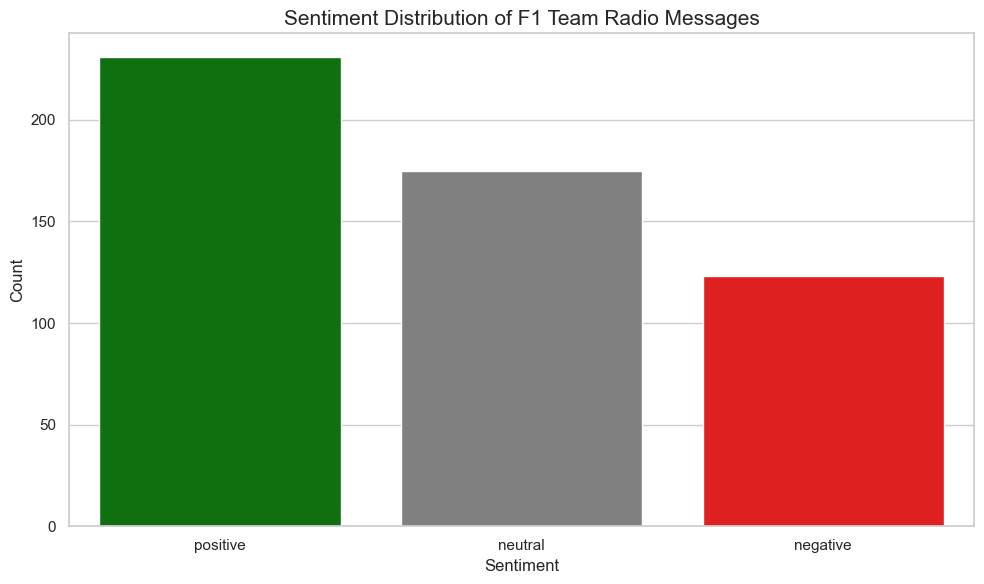

In [32]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=radio_data, palette={'positive': 'green', 'neutral': 'gray', 'negative': 'red'})
plt.title('Sentiment Distribution of F1 Team Radio Messages', fontsize=15)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

---
### Analyzing sentiment distribution by driver


<Figure size 1200x800 with 0 Axes>

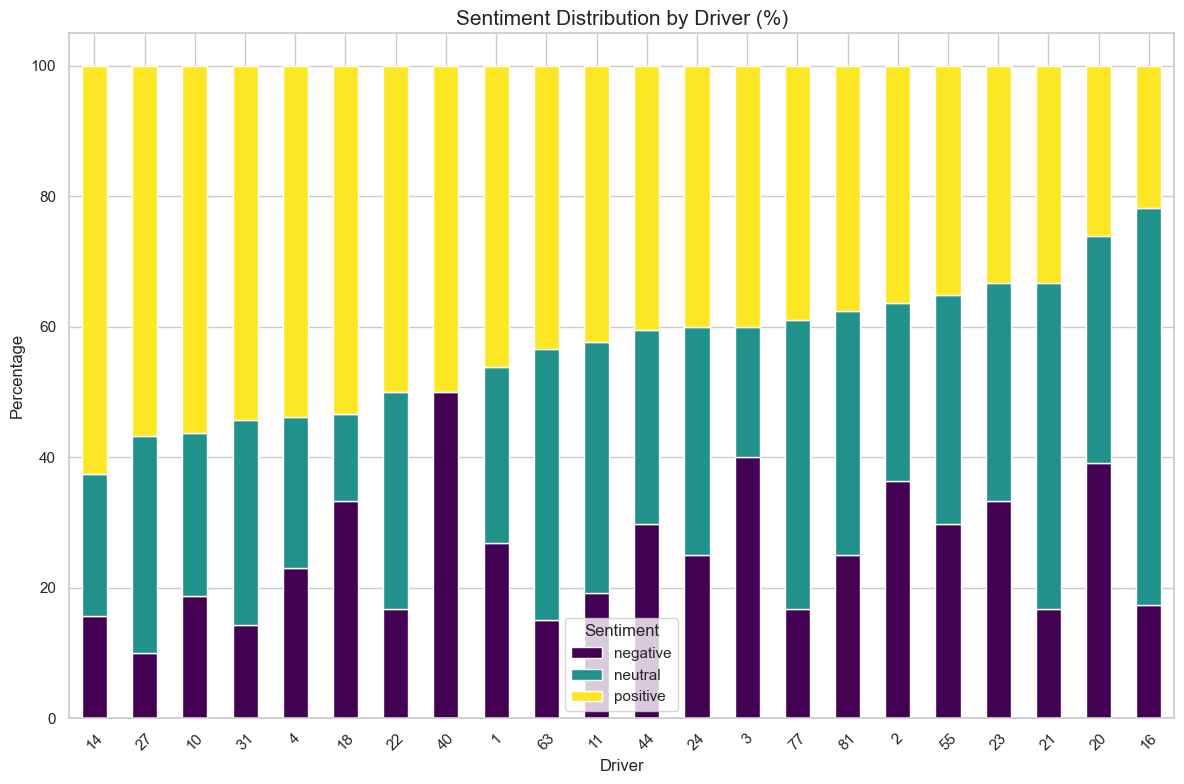

In [33]:
# Examine sentiment distribution by driver
driver_sentiment = pd.crosstab(radio_data['driver'], radio_data['sentiment'], normalize='index') * 100
driver_sentiment = driver_sentiment.sort_values(by='positive', ascending=False)

# Plot driver sentiment distribution
plt.figure(figsize=(12, 8))
driver_sentiment.plot(kind='bar', stacked=True, 
                     colormap='viridis', figsize=(12, 8))
plt.title('Sentiment Distribution by Driver (%)', fontsize=15)
plt.xlabel('Driver', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

#### Key observations

1. *Driver Sentiment Variability*: The visualization reveals dramatic differences in communication sentiment across F1 drivers:

    * Drivers on the left (14, 10, 4, 3) show overwhelmingly positive communications (yellow), with 70-90% positive sentiment.

    * Middle-range drivers (11, 27, 1) display increasing proportions of neutral communications.
    
    * Drivers on the right side (55, 2, 20, 16) exhibit significantly higher neutral sentiment percentages (green), with some reaching 50-67% neutral.


2. *Distinct Sentiment Patterns and Outliers*:

    * Driver 40 stands out with the highest negative sentiment percentage (purple), reaching approximately 42% of communications.
    
    * A clear gradient exists across drivers, with neutral sentiment gradually increasing from left to right.
    
    * Most drivers maintain at least 30% positive sentiment regardless of position, suggesting a baseline of positive communication exists across all teams/drivers.




---
### Displaying examples of each sentiment category

In [34]:
# Display examples of each sentiment category
def display_examples(sentiment_type, n=10):
    examples = radio_data[radio_data['sentiment'] == sentiment_type].sort_values(
        by='compound', ascending=(sentiment_type == 'negative'))
    return examples[['driver', 'radio_message', 'compound']].head(n)



In [35]:
print("Examples of POSITIVE messages:")
display_examples('positive')

Examples of POSITIVE messages:


,driver,radio_message,compound
383,44,"I think it's another lap man. Yes mate, yes. J...",0.9875
347,40,"Okay Liam, so Yuki got a penalty and that's P1...",0.9823
120,14,At the moment we will be faster in this. Yeah ...,0.9779
162,18,"One switch cool Lance, one switch cool, keep y...",0.9737
212,23,Car feels pretty good. It feels like exactly a...,0.9718
274,27,"Do you want to flap adjust, Nico? Not really, ...",0.9653
320,4,"Digestion, yellow G2 Yeah, none of this is hel...",0.9360
492,63,Oh no no What the f*** Guys what the f*** What...,0.9349
97,14,"Happy for the romance? Yeah, happy. No problem...",0.9300
112,14,So there is a small chance of rain in about 10...,0.9118


In [36]:
print("\nExamples of NEUTRAL messages:")
display_examples('neutral')


Examples of NEUTRAL messages:


,driver,radio_message,compound
46,1,"Max, I will say it again, there is no merit at...",0.0414
286,31,The grip of the steering wheel is falling apar...,0.0387
289,31,This is new material so I wouldn't be surprise...,0.0274
6,1,This time I had reasonable deg in the first st...,0.0000
12,1,I'm just picking up.,0.0000
3,1,Just another two or three minutes to get throu...,0.0000
2,1,You might find this lap that you meet a little...,0.0000
18,1,There are some pockets of rain a few kilometre...,0.0000
22,1,"Alonso has pitted for dry tyres. Understood, M...",0.0000
34,1,Is it gonna be like extreme tyre or Inter? Dif...,0.0000


In [37]:
print("\nExamples of NEGATIVE messages:")
display_examples('negative')


Examples of NEGATIVE messages:


,driver,radio_message,compound
491,63,No! No! No! No!,-0.8388
516,81,"Oscar, kill the engine. The car is not safe to...",-0.7967
105,14,The most damage is done after the tunnel break...,-0.7897
399,55,What the f***? Exactly what I talked about! Ex...,-0.7715
130,16,"No, I lost the hydraulics. I lost the hydrauli...",-0.7319
333,4,"How's the balance? How's the balance? Well, no...",-0.6915
168,2,"Where's Bortas? Bortas has retired, no threat.",-0.6808
264,27,"A lot of understeer creeping in, all speeds bu...",-0.6798
51,1,"In the low speed, from back steering to openin...",-0.6705
510,77,"Okay Valtteri, no more shifts, no more shifts,...",-0.6486


---

### Saving the sentiment vader results


In [38]:
output_path = "../../outputs/week4/radios_sentiment_vader.csv"
radio_data.to_csv(output_path, index = False)
print(f"Sentiment analysis results saved to {output_path}")

Sentiment analysis results saved to ../../outputs/week4/radios_sentiment_vader.csv


---

## Making metrics for future comparison with other models

In [39]:
# Calculate metrics for future comparison with other models
metrics = {
    'model': 'VADER',
    'positive_percentage': sentiment_counts.get('positive', 0) / len(radio_data) * 100,
    'neutral_percentage': sentiment_counts.get('neutral', 0) / len(radio_data) * 100,
    'negative_percentage': sentiment_counts.get('negative', 0) / len(radio_data) * 100,
    'average_compound': radio_data['compound'].mean(),
    'std_compound': radio_data['compound'].std()
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('../../outputs/week4/sentiment_metrics_vader.csv', index=False)
print("Summary metrics:")
metrics_df

Summary metrics:


,model,positive_percentage,neutral_percentage,negative_percentage,average_compound,std_compound
0,VADER,43.667297,33.081285,23.251418,0.127667,0.376898


--- 

## Next Steps: BERT-based Sentiment Analysis

While NLTK's VADER provides a quick, lexicon-based sentiment analysis, deep learning models 
like BERT can potentially offer better performance, especially for domain-specific language 
like F1 team radio communications.

Moreover, with this sentiment analysis, we can´t extract metrics for mistakes, like false positives. For this, we´ll need to label the data.

### But first: labeling the data

I think it is a good idea to label myself the data. With the correct labeling, I can try to make a comparison between the results given by VADER and then the others.

Because of that, I´ll add the `N00_labeling_radios.ipynb`, where I will label the data.

But...

#### **When labeling data, we will exclude end-of-race messages for the following reasons:**
Why?

* Project Focus: Our model aims to support real-time strategic decision-making during races, not post-race analysis.

* Different Context: End-of-race communications follow different patterns (congratulatory, reflective) than tactical in-race messages.

* Sentiment Distortion: Including these highly emotional messages would create an unrealistic sentiment distribution compared to the strategic communications we need to analyze.
---

#### Therefore, in the labelling radios notebook, I´ll make this cleaning before labeling. If the dataset gets highly reduced, I may need to rerun the code with new radio messages. 

This happened, so I added 3 more Grand Prix to have more data. I will rerun the code and change the percentages. Then, I will run the code again without the post-race messages.

---
### Approaches for BERT-based sentiment analysis:

1. **Using pretrained BERT models**:
   - Apply a pretrained BERT model fine-tuned for sentiment analysis (e.g., from Hugging Face)
   - This approach doesn't require labeled data from our domain

2. **Fine-tuning BERT with our data**:
   - Requires manually labeling a subset of our radio messages
   - Could capture F1-specific sentiment expressions better
   - Steps:
     a. Sample a subset of messages (e.g., 100-200)
     b. Manually label them (positive, neutral, negative)
     c. Fine-tune a pretrained BERT model with these labeled examples
     d. Evaluate performance
---
## Metrics for comparison:
- Distribution of sentiment categories
- Manual evaluation of a sample of predictions
- If we create a labeled test set, we can calculate precision, recall, and F1 scores
